[Forecasting: Principles and Practice](https://otexts.com/fpp2/)

In [1]:
from graph_traffic.get_data import get_data, ubs_index
from graph_traffic.dataloading import npzDataset
from graph_traffic.baseline_models import MeanRegressor, MedianRegressor, RepeatRegressor, RepeatLastRegressor, DaytimeRegressor, DriftRegressor
from graph_traffic.model_selection import timeseries_cv, plot_predictions
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from random import choices
from sklearn.metrics import mean_squared_error
import pandas as pd

data_dict = dict(
    ids_list=[3954, 3973, 3978],
    seq_len=4,
    with_graph=False,
    from_date="2019-03-01",
    to_date="2020-03-31",
    dataset_name="small",
    target="intensidad",
    interactions=None
)

meteo_dict = dict(
    rain="drop",
    wind="drop",
    temperature="drop",
    humidity="drop",
    pressure="drop",
    radiation="drop"
)

temporal_dict = dict(
    season="drop",
    month="drop",
    day_of_month="drop",
    hour="passthrough",
    minute="drop",
    bank_holiday="drop",
    school_holiday="drop",
    working_day="passthrough"
)

get_data(data_dict, meteo_dict, temporal_dict)
dataset_name = data_dict["dataset_name"]
n_points = None

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)

train_x = train_data.x
train_y = train_data.y

In [3]:
random_samples = choices(range(train_x.shape[0]), k=5)
random_samples

[11161, 459, 6746, 25595, 7643]

In [4]:
random_samples = [1936, 17977, 19114, 10526, 7173]

# 1. Mean regressor

In [5]:
train_losses, test_losses, predictions = timeseries_cv(MeanRegressor(), train_x, train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 235.81, std: 6.19
Test MAE: 231.29, std: 16.30


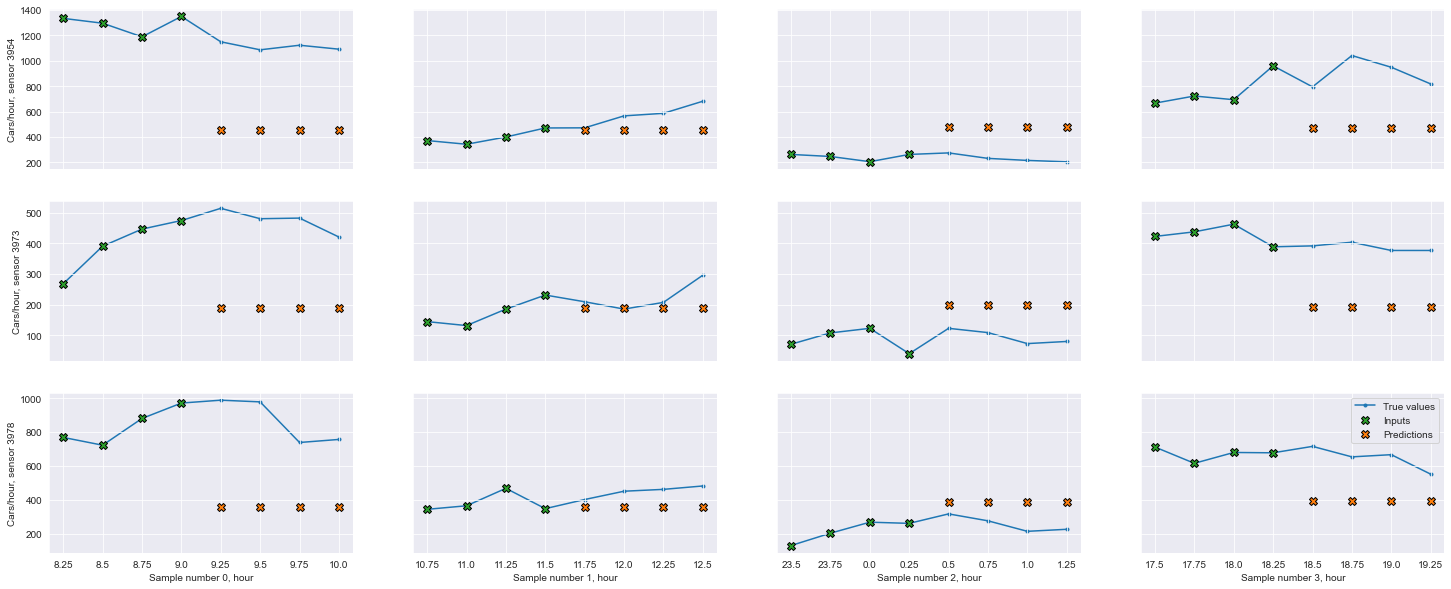

In [6]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

# 2. Median regressor

In [8]:
train_losses, test_losses, predictions = timeseries_cv(MedianRegressor(), train_x, train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 231.29, std: 6.91
Test MAE: 225.19, std: 22.54


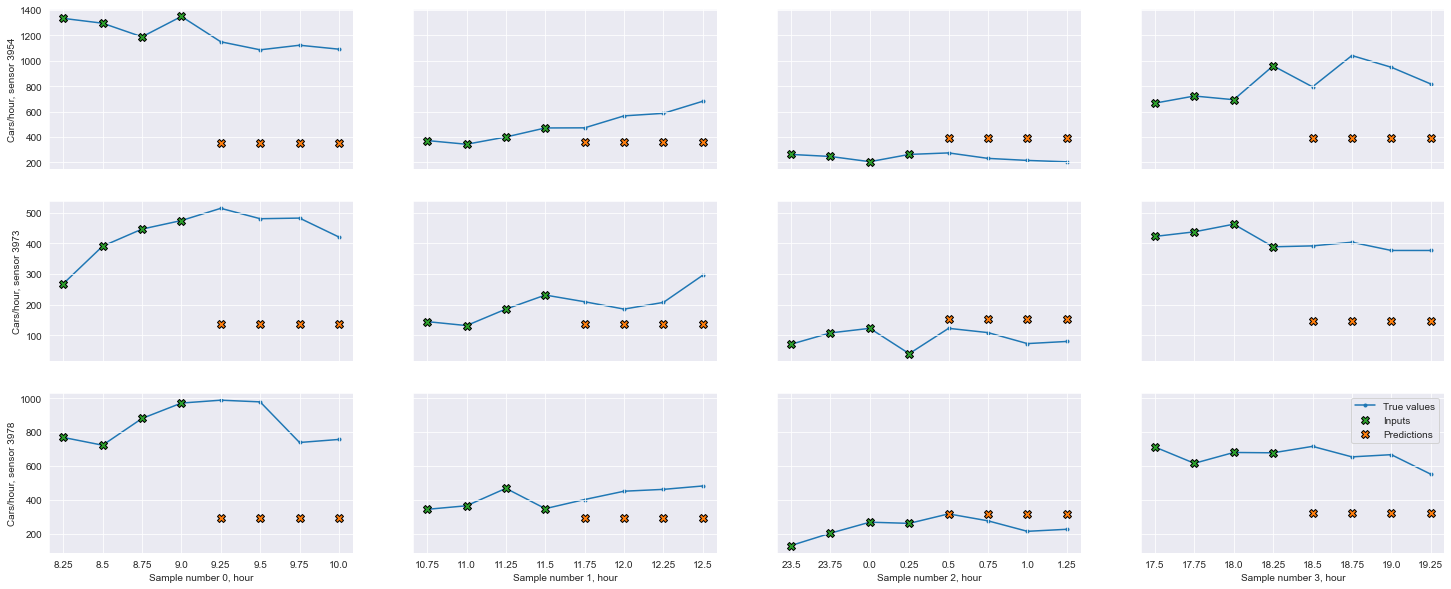

In [9]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

# 3. Repeat regressor

In [12]:
train_losses, test_losses, predictions = timeseries_cv(RepeatRegressor(), train_x, train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 90.78, std: 3.47
Test MAE: 88.79, std: 10.84


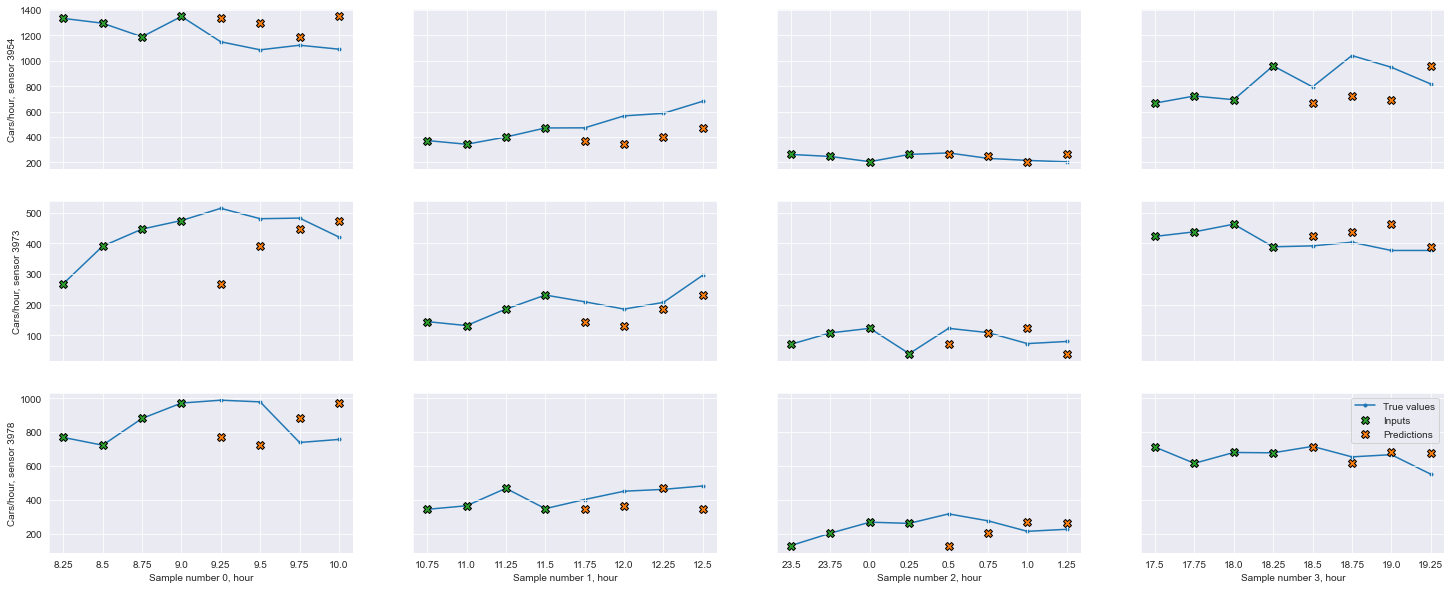

In [13]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

# 4. Repeat last value regressor

In [14]:
train_losses, test_losses, predictions = timeseries_cv(RepeatLastRegressor(), train_x, train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 69.54, std: 2.46
Test MAE: 68.12, std: 7.58


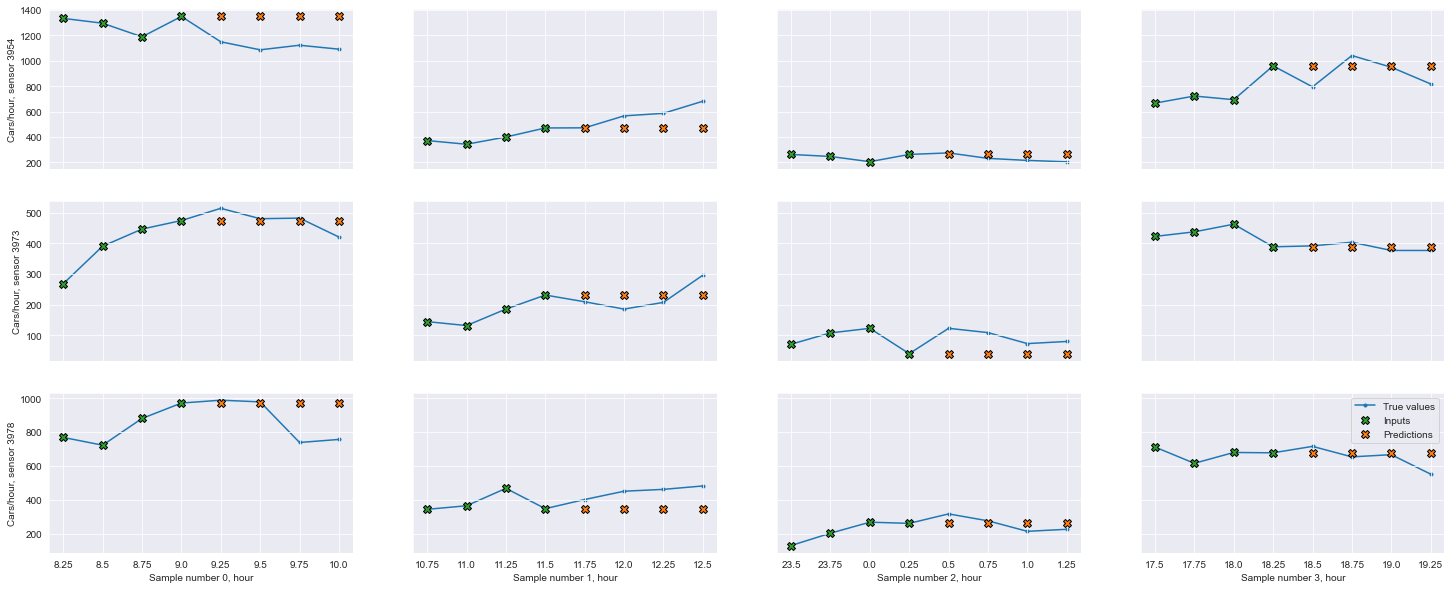

In [15]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

# 5. Mean per hour

In [16]:
train_losses, test_losses, predictions = timeseries_cv(DaytimeRegressor("mean"), train_x[:, :, :, [0, 1]], train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 161.90, std: 8.86
Test MAE: 161.44, std: 11.64


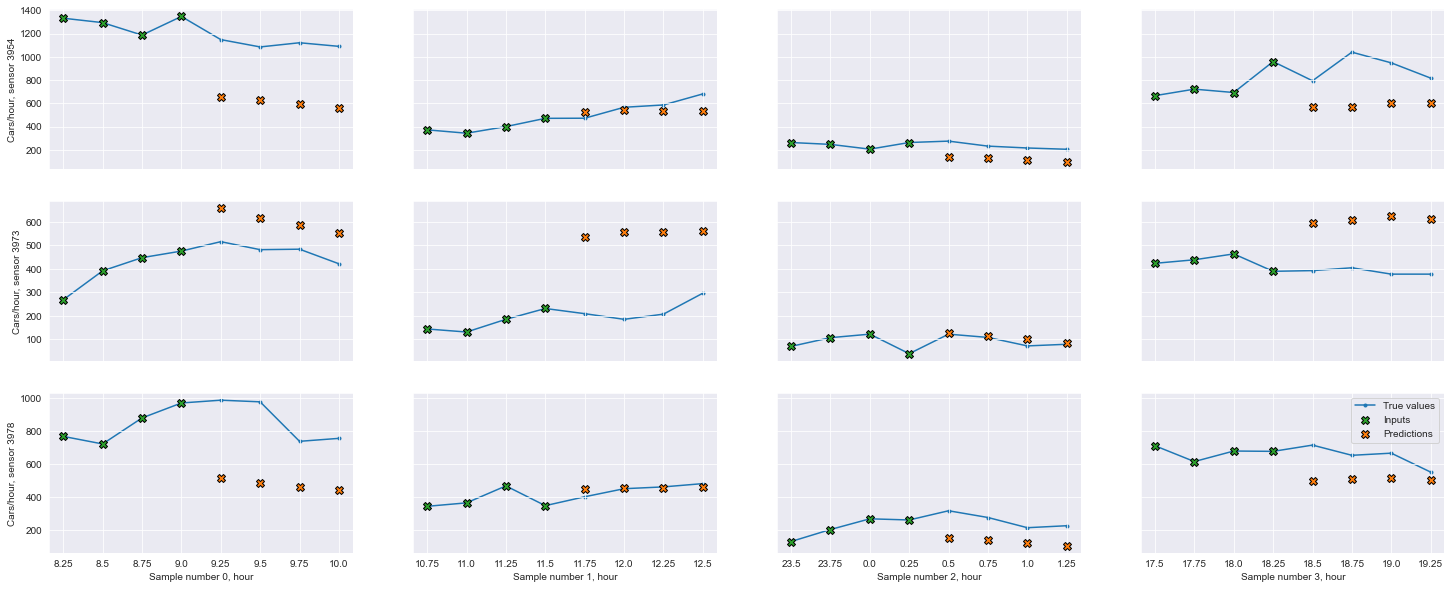

In [17]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

In [18]:
train_losses, test_losses, predictions = timeseries_cv(DaytimeRegressor("mean", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y,
                                                       predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 119.52, std: 9.74
Test MAE: 122.39, std: 11.25


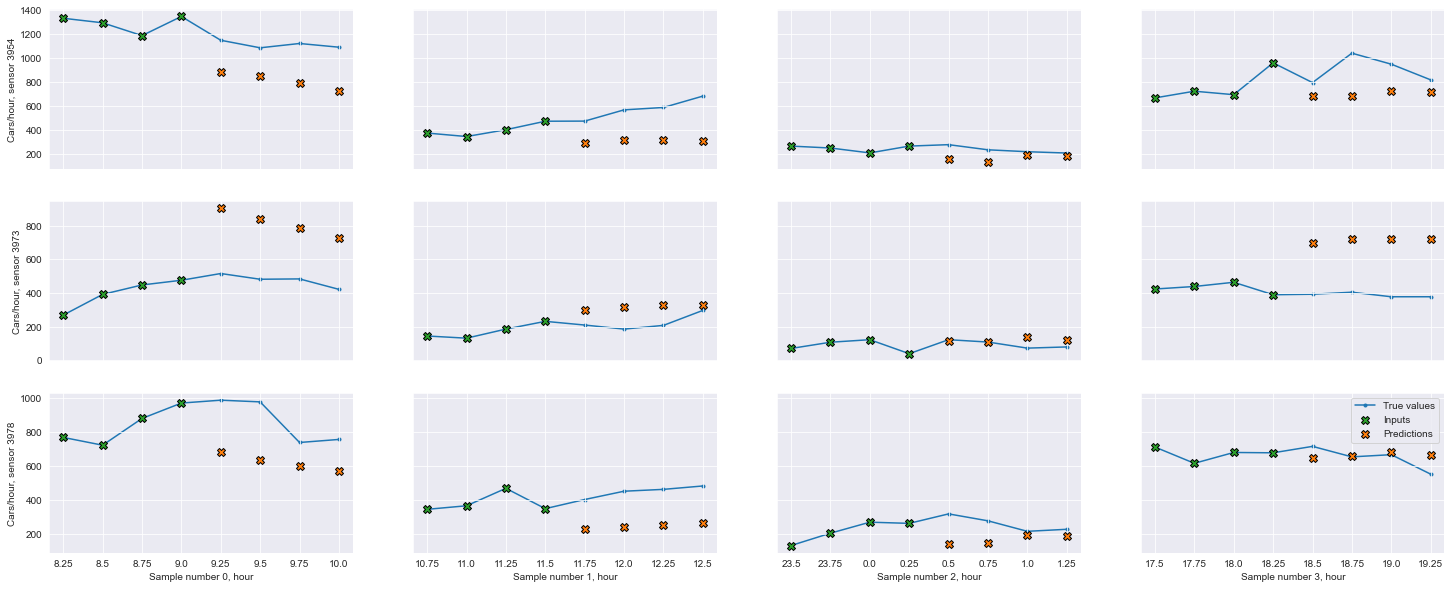

In [19]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

# 6. Median per hour

In [20]:
train_losses, test_losses, predictions = timeseries_cv(DaytimeRegressor("median"), train_x[:, :, :, [0, 1]], train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 157.74, std: 8.52
Test MAE: 156.36, std: 13.78


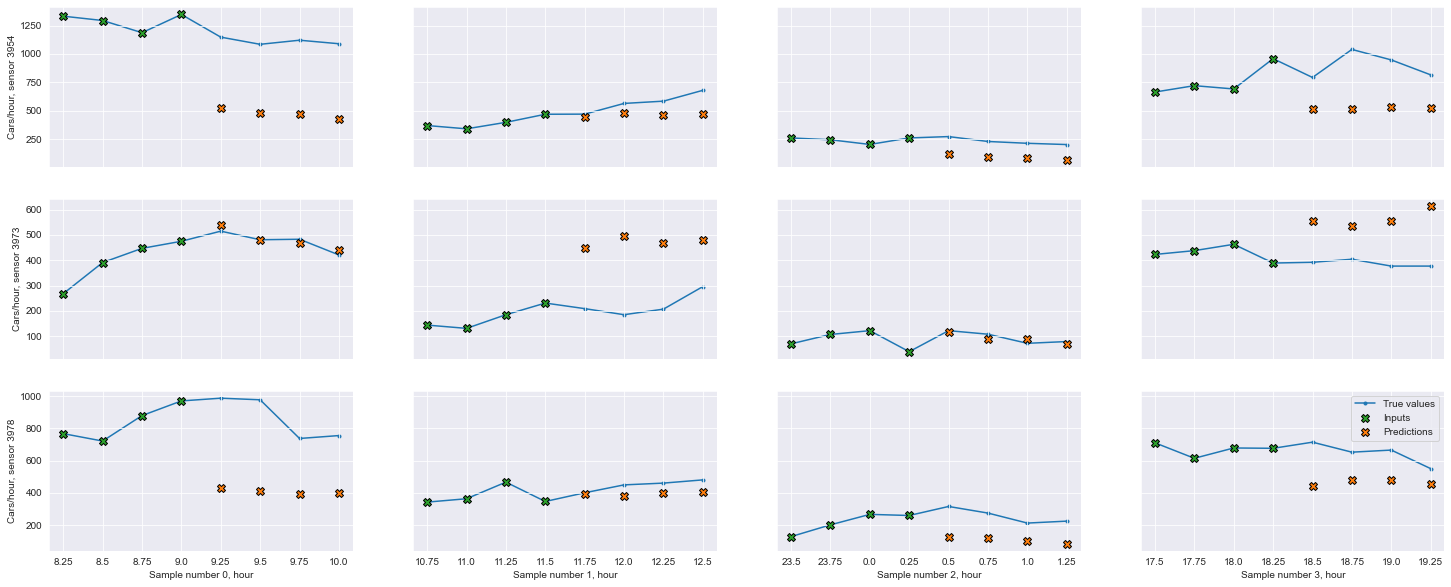

In [21]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

In [22]:
train_losses, test_losses, predictions = timeseries_cv(DaytimeRegressor("median", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 117.27, std: 12.24
Test MAE: 121.68, std: 13.17


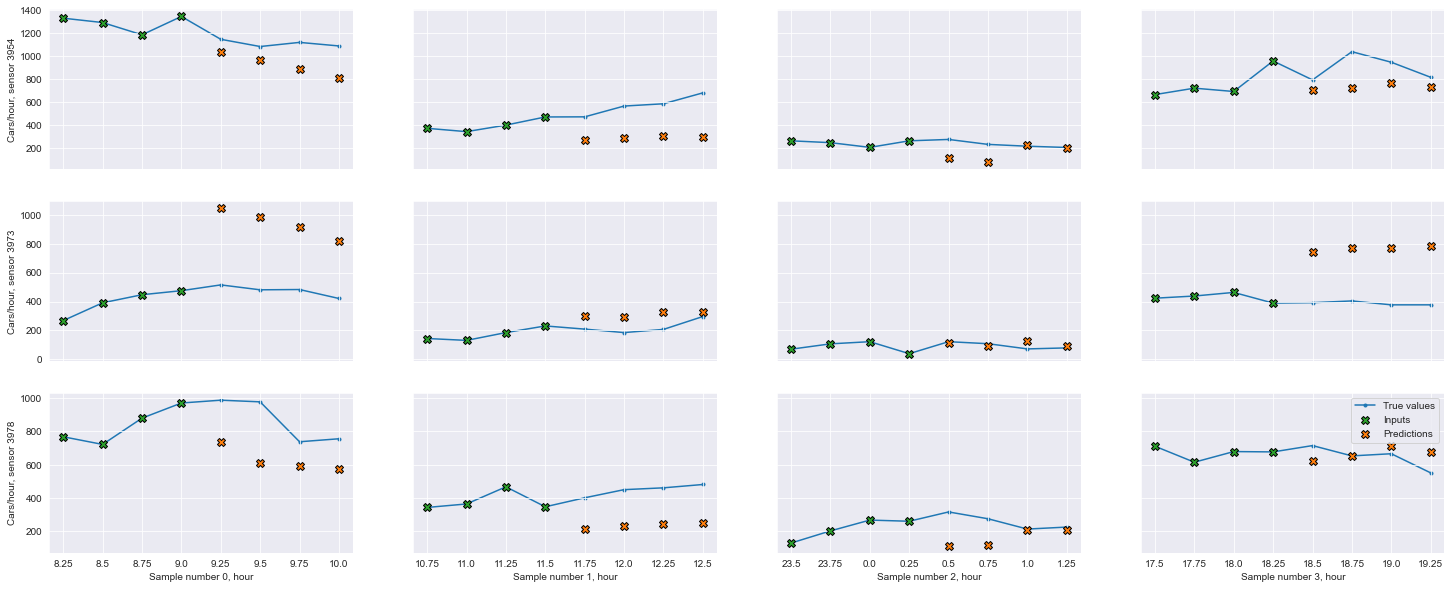

In [23]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

# 7. Drift regressor

In [24]:
train_losses, test_losses, predictions = timeseries_cv(DriftRegressor(), train_x, train_y, predict=random_samples)
mean_train_loss = np.mean(train_losses)
mean_test_loss = np.mean(test_losses)
print(f"Train MAE: {mean_train_loss:.2f}, std: {np.std(train_losses):.2f}")
print(f"Test MAE: {mean_test_loss:.2f}, std: {np.std(test_losses):.2f}")

Train MAE: 79.94, std: 2.58
Test MAE: 78.67, std: 8.14


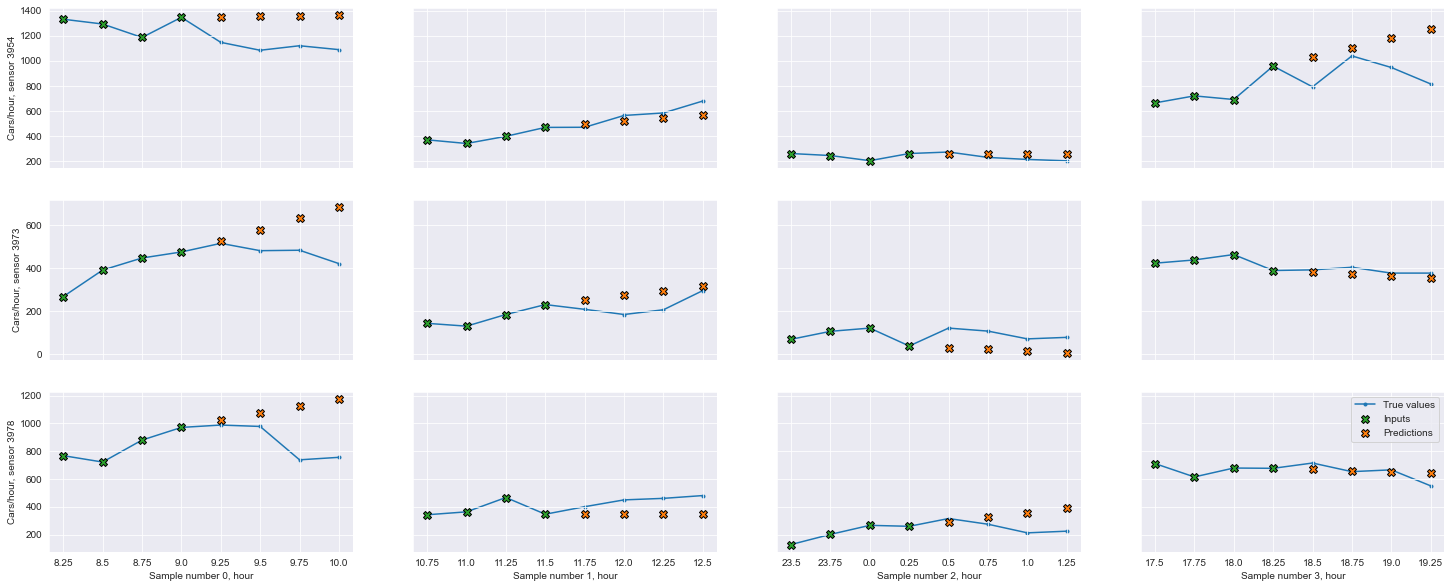

In [25]:
plot_predictions(train_x, train_y, random_samples, predictions, data_dict["ids_list"], data_dict["seq_len"])

# Old code

In [52]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [54]:
acorr_ljungbox(res, lags=5)

,lb_stat,lb_pvalue
1,38331.365109,0.0
2,61634.589144,0.0
3,87264.089048,0.0
4,105711.441395,0.0
5,112263.177690,0.0


In [56]:
acorr_ljungbox(res, lags=10)

,lb_stat,lb_pvalue
1,38331.365109,0.0
2,61634.589144,0.0
3,87264.089048,0.0
4,105711.441395,0.0
5,112263.177690,0.0
6,116983.880889,0.0
7,118493.435964,0.0
8,120959.158414,0.0
9,121208.738282,0.0
10,121724.623876,0.0


In [4]:
mean_reg = MeanRegressor()
mean_reg.fit(x_train, y_train)
train_pred = mean_reg.predict(x_train)
#valid_pred = mean_reg.predict(x_valid)
test_pred = mean_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred-y_train).mean():.2f}")
#print(f"Validation MRE: {np.abs(valid_pred-y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred-y_test).mean():.2f}")

Training MRE: 231.19
Test MRE: 248.84


In [35]:
median_reg = MedianRegressor()
median_reg.fit(x_train, y_train)
train_pred = median_reg.predict(x_train)
valid_pred = median_reg.predict(x_valid)
test_pred = median_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred-y_train).mean():.2f}")
print(f"Validation MRE: {np.abs(valid_pred-y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred-y_test).mean():.2f}")

Training MRE: 225.26
Validation MRE: 229.88
Test MRE: 243.76


In [50]:
drift_reg = DriftRegressor()
drift_reg.fit(x_train, y_train)
train_pred = drift_reg.predict(x_train)
valid_pred = drift_reg.predict(x_valid)
test_pred = drift_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred - y_train).mean():.2f}")
print(f"Validation MRE: {np.abs(valid_pred - y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred - y_test).mean():.2f}")

Training MRE: 78.15
Validation MRE: 82.71
Test MRE: 82.03


In [51]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

0.856373022226408

In [37]:
repeat_reg = RepeatRegressor()
repeat_reg.fit(x_train, y_train)
train_pred = repeat_reg.predict(x_train)
valid_pred = repeat_reg.predict(x_valid)
test_pred = repeat_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred - y_train).mean():.2f}")
print(f"Validation MRE: {np.abs(valid_pred - y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred - y_test).mean():.2f}")

Training MRE: 88.29
Validation MRE: 93.74
Test MRE: 91.22


In [38]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

0.7481399510265587

In [39]:
repeatlast_reg = RepeatLastRegressor()
repeatlast_reg.fit(x_train, y_train)
train_pred = repeatlast_reg.predict(x_train)
valid_pred = repeatlast_reg.predict(x_valid)
test_pred = repeatlast_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred - y_train).mean():.2f}")
print(f"Validation MRE: {np.abs(valid_pred - y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred - y_test).mean():.2f}")

Training MRE: 67.80
Validation MRE: 71.52
Test MRE: 70.08


In [40]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

0.6298384818233189

In [4]:
daytimemean_reg = DaytimeRegressor("mean")
daytimemean_reg.fit(x_train[:, :, :, [0, 1]], y_train)
train_pred = daytimemean_reg.predict(x_train)
#valid_pred = daytimemean_reg.predict(x_valid)
test_pred = daytimemean_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred - y_train).mean():.2f}")
#print(f"Validation MRE: {np.abs(valid_pred - y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred - y_test).mean():.2f}")

Training MRE: 152.17
Test MRE: 174.76


In [6]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

NameError: name 'train_pred' is not defined

In [43]:
daytimeworkingdaymean_reg = DaytimeRegressor("mean", by_working_day=True)
daytimeworkingdaymean_reg.fit(x_train[:, :, :, [0, 1, 2]], y_train)
train_pred = daytimeworkingdaymean_reg.predict(x_train)
valid_pred = daytimeworkingdaymean_reg.predict(x_valid)
test_pred = daytimeworkingdaymean_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred - y_train).mean():.2f}")
print(f"Validation MRE: {np.abs(valid_pred - y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred - y_test).mean():.2f}")

Training MRE: 134.16
Validation MRE: 138.43
Test MRE: 166.42


In [44]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

-103.60850535569408

In [36]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

-90.29161565266529

In [45]:
daytimemedian_reg = DaytimeRegressor("median")
daytimemedian_reg.fit(x_train[:, :, :, [0, 1]], y_train)
train_pred = daytimemedian_reg.predict(x_train)
valid_pred = daytimemedian_reg.predict(x_valid)
test_pred = daytimemedian_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred - y_train).mean():.2f}")
print(f"Validation MRE: {np.abs(valid_pred - y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred - y_test).mean():.2f}")

Training MRE: 170.99
Validation MRE: 174.97
Test MRE: 190.41


In [46]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

-161.31172301751744

In [47]:
daytimeworkingdaymedian_reg = DaytimeRegressor("median", by_working_day=True)
daytimeworkingdaymedian_reg.fit(x_train[:, :, :, [0, 1, 2]], y_train)
train_pred = daytimeworkingdaymedian_reg.predict(x_train)
valid_pred = daytimeworkingdaymedian_reg.predict(x_valid)
test_pred = daytimeworkingdaymedian_reg.predict(x_test)
print(f"Training MRE: {np.abs(train_pred - y_train).mean():.2f}")
print(f"Validation MRE: {np.abs(valid_pred - y_valid).mean():.2f}")
print(f"Test MRE: {np.abs(test_pred - y_test).mean():.2f}")

Training MRE: 134.70
Validation MRE: 138.34
Test MRE: 166.91


In [48]:
res = (train_pred-y_train)[:, :, 0, 0].ravel()
res.mean()

-94.96779643058956